**Neural Networks**

We'll start with the Kaggle Titanic dataset. The dataset is a list of Titanic passengers with features such as class, age, sex and fare. We'll use these features to train a model, and use the model to predict whether or not each passenger survived. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from time import time

np.random.seed(1337)

df = pd.read_csv('titanicNN.csv')


In [2]:
df.head()

,Survived,Class,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


In [3]:
scaler = StandardScaler()

In [4]:
scaler.fit_transform?


We split the data 80-20 into training and test sets. In addition, we scale the data so that each column has mean 0 and standard deviation 1, and create one-hot vectors with the labels (analogous to dummy variables).

In [5]:
df_train = df.iloc[:712, :]

scaler = StandardScaler()
features = ['Class', 'Sex', 'Age', 'Fare']

X_train = scaler.fit_transform(df_train[features].values)
y_train = df_train['Survived'].values
y_train_onehot = pd.get_dummies(df_train['Survived']).values



In [6]:
X_train[:5, :]

array([[ 0.83290956,  0.74926865, -0.61259594, -0.51933199],
       [-1.55353553, -1.33463478,  0.6184268 ,  0.79718222],
       [ 0.83290956, -1.33463478, -0.30484025, -0.5054541 ],
       [-1.55353553, -1.33463478,  0.38761004,  0.42333654],
       [ 0.83290956,  0.74926865,  0.38761004, -0.50288412]])

In [7]:
y_train[:5]

array([0, 1, 1, 1, 0], dtype=int64)

In [8]:
y_train_onehot[:5]

array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [9]:
df_test = df.iloc[712:, :]

X_test = scaler.transform(df_test[features].values)
y_test = df_test['Survived'].values

 ## Benchmark

To create a basis for comparison, we train a Random Forest model and record the accuracy on the test set.

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
RandomForestClassifier?


In [13]:
model = RandomForestClassifier(random_state=0, verbose=3)
model = model.fit(X_train, y_train)

y_prediction = model.predict(X_test)
print("\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10

accuracy 0.8100558659217877


C:\Users\rajku\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


## 1-layer Neural Network

For the input, we have a vector of length 4 that represents each passenger's features. As an example, we consider the first passenger in the dataset.

In [14]:
print(X_train[0])

[ 0.83290956  0.74926865 -0.61259594 -0.51933199]


For the output, we want a vector of length 2 to represent the survival probabilities. A simple way to create this mapping is by using a 2x4 matrix. To start off, we generate a random matrix representing feature weights and apply the matrix to our input. We'll also add a bias term.

In [15]:
W = np.random.rand(2, 4) * 0.01

print(W)

[[0.00262025 0.00158684 0.00278127 0.00459317]
 [0.00321001 0.00518393 0.00261943 0.00976085]]


In [16]:
b = np.random.rand(2,) * 0.01

print(b)

[0.00732815 0.00115274]


In [17]:
result = np.dot(W, X_train[0]) + b

print(result)

[0.00661037 0.00103677]


To get the output vector to sum to 1, we apply a softmax mapping. The first element would now represent the probability that the passenger did not survive, and the second element represents the probability the passenger survives.

In [18]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

In [19]:
result = softmax(result)

print(result)

[0.5013934 0.4986066]


We can then compare the output vector to the actual label. We would have a 'good' model if the probability for the correct label was close to 1, and a 'bad' one if it was close to 0.

In [20]:
print(y_train_onehot[0])

[1 0]


In [21]:
label_index = np.argmax(y_train_onehot[0])

print(label_index)

0


In [22]:
print("predicted label-0 probability", result[label_index])

predicted label-0 probability 0.5013933977819183


We define loss to be the negative logarithm of the probability of the correct label. Taking the logarithm penalizes the model for having a high probability associated with the wrong label. Here we have the loss associated with the first passenger.

In [23]:
loss = -np.log(result[label_index])

print("loss for first passenger", loss)

loss for first passenger 0.6903642609116132


We run the calculation through all the passengers in the training set, and divide the total loss by the number of passengers to obtain the average loss.

In [24]:
for j in range(X_train.shape[0]):
    result = np.dot(W, X_train[j]) + b
    result = softmax(result)
        
    label_index = np.argmax(y_train_onehot[j])
    loss += -np.log(result[label_index])

loss = loss / float(X_train.shape[0])

print("average loss across all passengers", loss)

average loss across all passengers 0.6938940425068784


Now we iterate through 1000 iterations for random values of W and b, and keep the pair which minimizes the average loss.

In [25]:
min_loss = 1000
best_weights = ()

start = time()

for i in range(1000):
    W = np.random.rand(2, 4) / 10
    b = np.random.rand(2,) / 10

    scores = []
    loss = 0
    
    for j in range(X_train.shape[0]):
        result = np.dot(W, X_train[j]) + b
        result = softmax(result)
        scores.append(list(result))
        
        label_index = np.argmax(y_train_onehot[j])
        loss += -np.log(result[label_index])

    loss = loss / float(X_train.shape[0])
    y_prediction = np.argmax(np.array(scores), axis=1)
    accuracy = np.sum(y_prediction == y_train) / float(len(y_train))
    
    if loss < min_loss:
        min_loss = loss
        best_weights = (W, b)
        print("loss %s accuracy %s loop %s" % (round(loss, 3), round(accuracy, 3), i))

print("\ntime taken %s seconds" % str(time() - start))

loss 0.711 accuracy 0.317 loop 0
loss 0.698 accuracy 0.393 loop 1
loss 0.67 accuracy 0.772 loop 2
loss 0.663 accuracy 0.785 loop 4
loss 0.661 accuracy 0.749 loop 156
loss 0.659 accuracy 0.725 loop 452
loss 0.658 accuracy 0.787 loop 715

time taken 21.83057689666748 seconds


In [27]:
W, b = best_weights
scores = []

for j in range(X_test.shape[0]):
    result = np.dot(W, X_test[j]) + b
    result = softmax(result)
    scores.append(list(result))

y_prediction = np.argmax(np.array(scores), axis=1)

print("accuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

accuracy 0.7821229050279329


For each passenger, predictions for the test set were made by selecting the label with the highest probability. Despite the naïve approach, we obtain a prediction accuracy of 78%!

## 2-layer Neural Network

With the 1-layer neural network, we had a 2x4 weight matrix. To create more degrees of freedom, we can introduce intermediary matrices or 'layers'. For example, instead of having a mapping from a vector of length 4 to a vector of length 2, we'll have two mappings - first from 4 to 100, followed by 100 to 2.

In [ ]:
W_1 = np.random.rand(100, 4) * 0.01
b_1 = np.random.rand(100,) * 0.01
W_2 = np.random.rand(2, 100) * 0.01
b_2 = np.random.rand(2,) * 0.01

In [ ]:
result = np.dot(W_1, X_train[0]) + b_1

print(result)

In [ ]:
result = np.dot(W_2, result) + b_2

print(result)

As before we iterate through 1000 iterations of random values for W_1, b_1, W_2 and b_2, and keep the one which minimizes loss.

In [ ]:
min_loss = 1000
best_weights = ()

start = time()

for i in range(1000):
    W_1 = np.random.rand(100, 4) * 0.01
    b_1 = np.random.rand(100,) * 0.01
    W_2 = np.random.rand(2, 100) * 0.01
    b_2 = np.random.rand(2,) * 0.01
    
    scores = []
    loss = 0

    for j in range(X_train.shape[0]):
        result = np.dot(W_1, X_train[j]) + b_1
        result = np.dot(W_2, result) + b_2
        result = softmax(result)
        scores.append(list(result))
        
        label_index = np.argmax(y_train_onehot[j])
        loss += -np.log(result[label_index])

    loss = loss / float(X_train.shape[0])
    y_prediction = np.argmax(np.array(scores), axis=1)
    accuracy = np.sum(y_prediction == y_train) / float(len(y_train))
        
    if loss < min_loss:
        min_loss = loss
        best_weights = (W_1, b_1, W_2, b_2)
        print("loss %s accuracy %s loop %s" % (round(loss, 3), round(accuracy, 3), i))

print("\ntime taken %s seconds" % str(time() - start))

In [ ]:
W_1, b_1, W_2, b_2 = best_weights
scores = []

for j in range(X_test.shape[0]):
    result = np.dot(W_1, X_test[j]) + b_1
    result = np.dot(W_2, result) + b_2
    result = softmax(result)
    scores.append(list(result))
    
y_prediction = np.argmax(np.array(scores), axis=1)

print("accuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

Despite the greater degree of freedom, we get an accuracy score of only 64%.

## 3-layer Neural Network

We take this a step further by adding an additional layer, and similarly review model performance.

In [ ]:
min_loss = 1000
best_weights = ()

start = time()

for i in range(1000):
    W_1 = np.random.rand(100, 4) * 0.01
    b_1 = np.random.rand(100,) * 0.01
    W_2 = np.random.rand(100, 100) * 0.01
    b_2 = np.random.rand(100,) * 0.01
    W_3 = np.random.rand(2, 100) * 0.01
    b_3 = np.random.rand(2,) * 0.01
    
    scores = []
    loss = 0

    for j in range(X_train.shape[0]):
        result = np.dot(W_1, X_train[j]) + b_1
        result = np.dot(W_2, result) + b_2
        result = np.dot(W_3, result) + b_3
        result = softmax(result)
        scores.append(list(result))
        
        label_index = np.argmax(y_train_onehot[j])
        loss += -np.log(result[label_index])
        
    loss = loss / float(X_train.shape[0])
    y_prediction = np.argmax(np.array(scores), axis=1)
    accuracy = np.sum(y_prediction == y_train) / float(len(y_train))          
        
    if loss < min_loss:
        min_loss = loss
        best_weights = (W_1, b_1, W_2, b_2, W_3, b_3)
        print("loss %s accuracy %s loop %s" % (round(loss, 3), round(accuracy, 3), i))

print("\ntime taken %s seconds" % str(time() - start))

In [ ]:
W_1, b_1, W_2, b_2, W_3, b_3 = best_weights
scores = []

for j in range(X_test.shape[0]):
    result = np.dot(W_1, X_test[j]) + b_1
    result = np.dot(W_2, result) + b_2
    result = np.dot(W_3, result) + b_3    
    result = softmax(result)
    scores.append(list(result))
    
y_prediction = np.argmax(np.array(scores), axis=1)

print("accuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

We run into the same problem of suboptimal model performance, but this is not unexpected given the simplistic approach taken for illustrative purposes. We look to build on this in the next section by taking a systematic approach to optimizing the weight matrices and biases.

# Basic Neural Network - Titanic Dataset

Previously, we simply iterated through randomly-generated matrices and chose the best-performing one. We build on this approach by reducing loss in a systematic way via stochastic gradient descent. In particular, we'll be using TensorFlow, an open source library developed by Google, and Keras, a high-level wrapper on top of TensorFlow.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from time import time

np.random.seed(1337)

df = pd.read_csv('titanicNN.csv')

In [ ]:
df_train = df.iloc[:712, :]

scaler = StandardScaler()
features = ['Class', 'Sex', 'Age', 'Fare']

X_train = scaler.fit_transform(df_train[features].values)
y_train = df_train['Survived'].values
y_train_onehot = pd.get_dummies(df_train['Survived']).values

In [ ]:
df_test = df.iloc[712:, :]

X_test = scaler.transform(df_test[features].values)
y_test = df_test['Survived'].values

## Benchmark

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0, verbose=3)
model = model.fit(X_train, df_train['Survived'].values)

y_prediction = model.predict(X_test)
print("\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

## 1-layer Neural Network

Instead of generating a linear stack of layers with Numpy, we'll be implementing our model using Keras. We initialize our model, add a layer that inputs vectors of length 4 and outputs vectors of length 2, and finally add a softmax layer. We configure the learning process in the compilation step by specifying the optimizer, loss function and performance metric.

Stochastic gradient descent acts by changing the weights gradually in the 'direction' that decreases the average loss. In other words, a particular weight would be increased if acts to decrease loss, or the weight decreased if it acts to increase loss. TensorFlow does the heavy-lifting by efficiently handling these numerical computations under the hood. A simple example of stochastic gradient descent is illustrated in the Appendix.

In [ ]:
pip install keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
start = time()

model = Sequential()
model.add(Dense(input_dim=4, output_dim=2))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

In [2]:
!pip install keras


  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/90/85/64c82949765cfb246bbdaf5aca2d55f400f792655927a017710a78445def/Keras_Applications-1.0.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c0/bf/0315ef6a9fd3fc2346e85b0ff1f5f83ca17073f2c31ac719ab2e4da0d4a3/Keras_Preprocessing-1.0.9-py2.py3-none-any.whl


In [3]:
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/7b/14/e4538c2bc3ae9f4ce6f6ce7ef1180da05abc4a617afba798268232b01d0d/tensorflow-1.13.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/2a/22/bd327063dd0bdf9d8d640b3185b760707842160e69df909db3fcaab5b758/grpcio-1.20.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/35/6b/11530768cac581a12952a2aad00e1526b89d242d0b9f59534ef6e6a1752f/astor-0.7.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0f/39/bdd75b08a6fba41f098b6cb091b9e8c7a80e1b4d679a581a0ccd17b10373/tensorboard-1.13.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/48/13f49fc3fa0fdf916aa1419013bb8f2ad09674c275b4046d5ee669a46873/tensorflow_estimator-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/34/ef/f020691889031a8e1d8cb20711daa43cfe999e0768ff6903c4bf70c2eecd/protobuf-3.7.1-cp37-cp37m-win_amd64.whl
  Using cached https://files

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

We notice that the loss reduces systematically as the model 'learns' from the data. The rate of loss reduction, however, seems to indicate that loss could be further reduced.

## 2-layer Neural Network

In [ ]:
start = time()

model = Sequential()
model.add(Dense(input_dim=4,  output_dim=100))
model.add(Dense(output_dim=2))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

The loss reduction 'flattens out' more compared to the 1-layer example, and the accuracy improves to 81%.

## 3-layer Neural Network

In [ ]:
start = time()

model = Sequential()
model.add(Dense(input_dim=4, output_dim=100))
model.add(Dense(output_dim=100))
model.add(Dense(output_dim=2))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

While we're able to reduce loss on the training set a little further, the best performance obtained is merely comparable to our benchmark. Since the dataset is small, there isn't as much for the model to 'learn' from (or for that matter, predict on). We'll apply techniques developed so far on a much larger dataset in the next section.

# Basic Neural Network - MNIST Data

In this section, we'll apply techniques developed so far on the MNIST dataset. The MNIST dataset consists of hand-drawn digits from zero to nine. Each image is 28 pixels in height and 28 pixels in width, with the pixel value an integer between 0 and 255.

In [4]:
import numpy as np
import pandas as pd
# from itertools import izip
from sklearn.preprocessing import StandardScaler
from time import time

np.random.seed(1337)

df = pd.read_csv('mnist.csv')

For illustrative purposes, the first example is shown with pixel values between 0 and 10.

In [5]:
for item in df.iloc[0, 1:].values.reshape(28,28)/26:
    print(''.join(str(list(item)).split(' ')))

[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.230769230769231,9.807692307692308,3.6153846153846154,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.346153846153846,9.615384615384615,9.73076923076923,3.576923076923077,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.730769230769231,9.538461538461538,9.73076923076923,6.423076923076923,0.38461538461538464,0.0,0.0,0.0,0.0,0.0]
[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

A hand-drawn 1 can clearly be seen from the visualization in grayscale.

In [ ]:
# ! pip3 install matplotlib

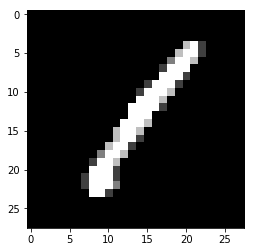

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(df.iloc[0, 1:].values.reshape(28,28), cmap=plt.get_cmap('gray', 5))
plt.show()

There are 42,000 images. We similarly split the images 80:20 into training and test sets, and scale the data through division by 255. 

In [9]:
df_train = df.iloc[:33600, :]

X_train = df_train.iloc[:, 1:].values / 255.
y_train = df_train['label'].values
y_train_onehot = pd.get_dummies(df_train['label']).values

In [10]:
df_test = df.iloc[33600:, :]

X_test = df_test.iloc[:, 1:].values / 255.
y_test = df_test['label'].values

## Benchmark

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0, verbose=3)
model = model.fit(X_train, df_train['label'].values)

y_prediction = model.predict(X_test)
print("\naccuracy", np.sum(y_prediction == df_test['label'].values) / float(len(y_test)))

C:\Users\rajku\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10

accuracy 0.9379761904761905


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


## 1-layer Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation

start = time()

model = Sequential()
model.add(Dense(input_dim=784, output_dim=10))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

Using TensorFlow backend.


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

SystemError: <class '_frozen_importlib._ModuleLockManager'> returned a result with an error set

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

## 2-layer Neural Network

In [ ]:
start = time()

model = Sequential()
model.add(Dense(input_dim=784, output_dim=100))
model.add(Dense(output_dim=10))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

## 3-layer Neural Network

In [ ]:
start = time()

model = Sequential()
model.add(Dense(input_dim=784, output_dim=100))
model.add(Dense(output_dim=100))
model.add(Dense(output_dim=10))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

As in the previous section, we were able to drive loss down even further with additional layers. While we see improvements in accuracy, it's still not enough to beat the benchmark. We'll look into more advanced techniques to enhance model performance in next section.

# Regularized Neural Network

In this section, we'll introduce two additional layers to our model. The first is called the rectified linear unit (hereafter, ReLU), which helps introduce non-linearity into the network. The second is called the dropout layer, which acts to regularize the network and prevent overfitting.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from time import time

np.random.seed(1337)

df = pd.read_csv('mnist.csv')


In [ ]:
df_train = df.iloc[:33600, :]

X_train = df_train.iloc[:, 1:].values / 255.
y_train = df_train['label'].values
y_train_onehot = pd.get_dummies(df_train['label']).values

In [ ]:
df_test = df.iloc[33600:, :]

X_test = df_test.iloc[:, 1:].values / 255.
y_test = df_test['label'].values

## Benchmark

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0, verbose=3)
model = model.fit(X_train, df_train['label'].values)

y_prediction = model.predict(X_test)
print("\naccuracy", np.sum(y_prediction == df_test['label'].values) / float(len(y_test)))

## Regularized NN

While matrix operations are linear, there could be a non-linear relationship between the features and the label. Introducing a ReLU layer, defined as f(x) = max(0, x), can help the model capture this interaction. ReLU is widely used as its simplicity allows for much faster training without a high cost to accuracy.

The dropout layer can be thought of as a form of sampling, where output values are randomly set to zero by a pre-specified probability. This creates a more robust network as the process prevents interdependence, and as such the model is less likely to overfit on the training data. It is surprisingly effective, which has made it an active area of research.

Following Andrej Karpathy's advice of "don't be a hero", the example shown here is from the Keras repository.

In [ ]:
# https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

start = time()

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\n\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

Introducing ReLU and dropout layers have enabled the model to outperform the benchmark by 2%! In the next section, we introduce new layers that take advantage of the 2D structure of the image to further improve model performance.

# Convolutional Neural Network

The approach we've taken so far treats each image a single 'flat' vector of length 784. In this section, we'll introduce layers that take advantage the 2D structure of each 28x28 MNIST image, helping simplify computation and improve model performance.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from time import time

np.random.seed(1337)

df = pd.read_csv('mnist.csv')

In [ ]:
df_train = df.iloc[:33600, :]

X_train = df_train.iloc[:, 1:].values / 255.
y_train = df_train['label'].values
y_train_onehot = pd.get_dummies(df_train['label']).values

In [ ]:
df_test = df.iloc[33600:, :]

X_test = df_test.iloc[:, 1:].values / 255.
y_test = df_test['label'].values

## Benchmark

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0, verbose=3)
model = model.fit(X_train, df_train['label'].values)

y_prediction = model.predict(X_test)
print("\naccuracy", np.sum(y_prediction == df_test['label'].values) / float(len(y_test)))

## CNN

The first layer we'll introduce is called the convolutional layer. Instead of having a weight matrix of shape (output length x input length), we'll instead consider a 3x3 weight matrix called a filter or kernel. We take the vector product of the filter with each (overlapping) 3x3 grid in the 28x28 image.

Since there are 26x26 such grids, a single filter results in a 26x26 output. 32 filters gives us an output 'volume' of shape 26x26x32. By making the 26x26x32 volume go through another convolutional layer, we end up with an output volume of shape 24x24x32.

The second new layer we'll use is called the pooling layer. Here we divide up the input into non-overlapping grids of size 2x2, and take the maximum value from each grid. For an 24x24x32 input, this results in 12x12x32 output. This volume is then 'flattened' to a vector of length 4,608, which we manipulate the same way as any vector.

The use of filters constraints the architecture of the network as each filter only focuses on a specific aspect of the data. This allows our model to scale better and be more translation-invariant. The pooling layer also reduces the number of parameters, helping reduce computation and limit overfitting.

An excellent detailed discussion, with architectural variations and helpful illustrations, can be found on Stanford's CS231n course notes:

http://cs231n.github.io/convolutional-networks/

In [ ]:
# https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten

start = time()

img_rows, img_cols = 28, 28
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.fit(X_train, y_train_onehot)

print('\ntime taken %s seconds' % str(time() - start))

In [ ]:
y_prediction = model.predict_classes(X_test)
print("\naccuracy", np.sum(y_prediction == y_test) / float(len(y_test)))

This is our best result yet! It is worth experimenting with different network architectures to see how they affect loss and accuracy. In the next section, we'll continue to take advantage of inherent data structures but apply it to text data.

# Regression

We've been using stochastic gradient descent for model training. In this section we'll discuss briefly how it works. For simplicity, we'll focus only on the features Sex and Fare.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from time import time

np.random.seed(1337)

df = pd.read_csv('titanicNN.csv')

In [ ]:
df_train = df.iloc[:712, :]

scaler = StandardScaler()
features = ['Sex', 'Fare']

X_train = scaler.fit_transform(df_train[features].values)
y_train = df_train['Survived'].values
y_train_onehot = pd.get_dummies(df_train['Survived']).values

In [ ]:
df_test = df.iloc[712:, :]

X_test = scaler.transform(df_test[features].values)
y_test = df_test['Survived'].values

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

Instead of using the random matrix we started with, we make slight adjustments to the weights at every step. We track the values for the weights and biases at the start and end, and evaluate model accuracy at these points.

In [ ]:
min_loss = 1000
best_weights = ()

W = np.random.rand(2, 2) * 0.01
b = np.random.rand(2,) * 0.01

scores = []
loss = 0

W_start = W
b_start = b
metrics = []

learning_rate = 0.001

for j in range(X_train.shape[0]):
    result = np.dot(W, X_train[j]) + b        
    W = W - learning_rate * np.dot((result - y_train_onehot[j]).reshape(2,1), X_train[j].reshape(1,2))
        
    result = softmax(result)
    scores.append(list(result))
        
    label_index = np.argmax(y_train_onehot[j])
    loss += -np.log(result[label_index])
    
    metrics.append([W[1, 0], W[1, 1], loss/(j+1)])
    
W_end = W
b_end = b
metrics = np.array(metrics)

In [ ]:
def accuracy(W, b):
    scores = []

    for j in range(X_test.shape[0]):
        result = np.dot(W, X_test[j]) + b
        result = softmax(result)
        scores.append(list(result))

    y_prediction = np.argmax(np.array(scores), axis=1)
    return np.sum(y_prediction == y_test) / float(len(y_test))

In [ ]:
print("accuracy at start", accuracy(W_start, b_start))
print("accuracy at end", accuracy(W_end, b_end))

In [ ]:
print("label-1 weights at start", W_start[1, :])
print("label-1 weights at end", W_end[1, :])

We notice that accuracy has improved significantly by these adjustments. Note that the label-1 weight for Sex goes from a positive value at initialization to a negative value. The model has 'learned' that the higher the value of this feature, the less likely that passenger would survive. This is indeed consistent with the data.

We visualize how the label-1 weights change over time, changing from red to green with the number of steps.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

border = 0.0025

fig1 = plt.figure(figsize=(50,10))
ax1 = plt.subplot(131)

alphas = np.linspace(0, 1, 356)
ones = np.ones(356)
rgba_colors = np.zeros((712,4))
rgba_colors[:, 0] = np.concatenate([ones, ones-alphas])
rgba_colors[:, 1] = np.concatenate([alphas, ones])
rgba_colors[:, 3] = np.ones(712)

ax1.scatter(metrics[:, 0], metrics[:, 1], c=rgba_colors, edgecolor=rgba_colors)
ax1.set_xlim([metrics[:, 0].min()-border, metrics[:, 0].max()+border])
ax1.set_ylim([metrics[:, 1].min()-border, metrics[:, 1].max()+border])

## Linear Regression with Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Generate dataset
trX = np.linspace(-1, 1, 101)
trY = 2 * trX + np.random.randn(*trX.shape) * 0.33 # create a y value which is approximately linear but with some random noise

In [ ]:
# Linear regression model
model = Sequential()
model.add(Dense(input_dim=1, output_dim=1, init='uniform', activation='linear'))
model.compile(optimizer='sgd', loss='mse') ## Stochastic Gradient Descent

In [ ]:
# Print initial weights
weights = model.layers[0].get_weights()
w_init = weights[0][0][0]
b_init = weights[1][0]
print('Linear regression model is initialized with weight w: %.2f, b: %.2f' % (w_init, b_init))

In [ ]:
# Train
model.fit(trX, trY, nb_epoch=100, verbose=1)

# Print trained weights
weights = model.layers[0].get_weights()
w = weights[0][0][0]
b = weights[1][0]
print('Linear regression model is trained with weight w: %.2f, b: %.2f' % (w, b))

In [ ]:
plt.plot(trX, trY, label='data')
plt.plot(trX, w_init*trX + b_init, label='init')
plt.plot(trX, w*trX + b, label='prediction')
plt.legend()
plt.show()

## Logistic Regression with Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import np_utils

In [ ]:
# Regression Settings
batch_size = 128
nb_classes = 10
nb_epoch = 100

In [ ]:
# Load MNIST dataset and split for train and test
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_Train = np_utils.to_categorical(y_train, nb_classes)
Y_Test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
# Logistic regression model
model = Sequential()
model.add(Dense(output_dim=10, input_shape=(784,), init='normal', activation='softmax'))
model.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Train
history = model.fit(X_train, Y_Train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

In [ ]:
# Evaluate
evaluation = model.evaluate(X_test, Y_Test, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

In [ ]:
# Decode test images 
# decoded_imgs = model.predict(X_test)
decoded_imgs = model.predict_classes(X_test)

In [ ]:
plt.imshow(X_test[1].reshape(28, 28))


In [ ]:
print(decoded_imgs[1])

# AutoEncoders

In [ ]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
import numpy as np

In [ ]:
# Autoencoder settings - Hyper parameters
batch_size = 128
nb_epoch = 100

In [ ]:
# Parameters (size) for MNIST dataset
img_rows, img_cols = 28, 28

In [ ]:
# Parameters for denoising autoencoder
nb_visible = img_rows * img_cols
nb_hidden = 500
corruption_level = 0.3

In [ ]:
# Load MNIST Dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

In [ ]:
# Add random noise
x_train_noisy = x_train + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape)
print(x_test_noisy.shape)

In [ ]:
# Build autoencoder model
input_img = Input(shape=(nb_visible,))
encoded = Dense(nb_hidden, activation='relu')(input_img)
decoded = Dense(nb_visible, activation='sigmoid')(encoded)

autoencoder = Model(input=input_img, output=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
# Train
autoencoder.fit(x_train_noisy, x_train,
                nb_epoch=20, batch_size=batch_size, shuffle=True, verbose=1,
                validation_data=(x_test_noisy, x_test))

In [ ]:
# Evaluate
evaluation = autoencoder.evaluate(x_test_noisy, x_test, batch_size=batch_size, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))

In [ ]:
# Decode test images 
decoded_imgs = autoencoder.predict(x_test_noisy)

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()